# Chapter 3
## Association Analysis

In [1]:
import pandas as pd
import numpy as np

import datetime as dt

import matplotlib.pyplot as plt 

import gower
import math
from sklearn.cluster import DBSCAN
import time
import sklearn
import mlxtend
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [2]:
print(mlxtend.__version__)
print(sklearn.__version__)


0.19.0
1.1.0


In [3]:
c_co_in=pd.read_csv('../data/association_c_co_in.csv', sep=',', index_col=0,low_memory=False)
c_co_out=pd.read_csv('../data/association_c_co_out.csv', sep=',', index_col=0,low_memory=False)
c_co_out['OwnerSince']=pd.to_datetime(c_co_out['OwnerSince'], utc=True) 
c_co_out['OwnerTill']=pd.to_datetime(c_co_out['OwnerTill'], utc=True) 

In [4]:
a=pd.to_datetime('01JAN19:00:00:00',format='%d%b%y:%H:%M:%S', utc=False)
c_co_out['seconds']=(c_co_out['OwnerSince'].dt.tz_localize(None)-pd.to_datetime(a)).dt.total_seconds()/10 #miliseconds eliminated
c_co_out['seconds_2']=c_co_out['seconds']
c_co_out[c_co_out.columns[[1,3,-2,-1]]].head(2)

,NextOwnerId,OwnerSince,seconds,seconds_2
1,d9d8a373-29f0-4fe5-8f17-39669083ac48,2019-09-23 07:29:08.691234+00:00,2.292295e+06,2.292295e+06
3,cb1f92f7-ffbb-43a6-b741-b1d71cb2a157,2019-09-23 07:29:29.218375+00:00,2.292297e+06,2.292297e+06


In [5]:
# dbscan date by date
#dic=dict()
c_co_out['trans_id_2']=pd.Series()
start_time = time.time()
for date in c_co_out['OwnerSince'].dt.date.unique():
    df=c_co_out[c_co_out['OwnerSince'].dt.date==date].copy()
    dist_matrix = gower.gower_matrix(df[['seconds','NextOwnerId']])
    db = DBSCAN(eps = 0.01, min_samples = 2, metric = "precomputed").fit(dist_matrix)
    #dic[date]=db.labels_
    labels = db.labels_


    df['cluster']=labels
    df['trans_id_2']=(str(date)+'_'+df[df['cluster']>-1]['cluster'].astype(str)  )
    x=df[df['cluster']>-1]
    #print(id_, x.shape)
    c_co_out.update(x['trans_id_2'])
    
    
print("--- %s seconds ---" % (time.time() - start_time))
c_co_out.to_csv('../data/association_c_co_out.csv')

/var/folders/bs/8_rscwxd25z1bcq4d89vsz380000gn/T/ipykernel_15653/1748386177.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  c_co_out['trans_id_2']=pd.Series()


--- 453.68365383148193 seconds ---


In [6]:
c_co_out[c_co_out['trans_id_2'].isna()==False].shape

(82800, 18)

In [7]:
c_co_out.shape

(281719, 18)

In [8]:
c_co_out[c_co_out['trans_id_2'].isna()==False][['NextOwnerId','OwnerSince','seconds','trans_id_2' ]].head(10)

,NextOwnerId,OwnerSince,seconds,trans_id_2
16,2402b7c2-b627-43eb-ae6d-f95f1680e6fd,2019-09-23 07:53:16.247241+00:00,2.292440e+06,2019-09-23_0
17,2402b7c2-b627-43eb-ae6d-f95f1680e6fd,2019-09-23 07:53:29.774347+00:00,2.292441e+06,2019-09-23_0
34,786b4bd1-99cb-4bed-99f9-c5fec05c006c,2019-09-23 08:14:30.539862+00:00,2.292567e+06,2019-09-23_1
38,ba1cffbb-44ad-4099-9f03-4a773b16a6a3,2019-09-23 08:15:09.339326+00:00,2.292571e+06,2019-09-23_2
41,63890c0a-24ea-475b-8fe0-ab2a7071b226,2019-09-23 08:15:35.965192+00:00,2.292574e+06,2019-09-23_3
43,63890c0a-24ea-475b-8fe0-ab2a7071b226,2019-09-23 08:15:57.340226+00:00,2.292576e+06,2019-09-23_3
45,4d847de3-570d-4210-bdfe-9c3511fbefdd,2019-09-23 08:16:11.875092+00:00,2.292577e+06,2019-09-23_4
46,ba1cffbb-44ad-4099-9f03-4a773b16a6a3,2019-09-23 08:16:19.533157+00:00,2.292578e+06,2019-09-23_2
50,14360558-42d7-4162-b177-121c9be4ed4c,2019-09-23 08:19:39.260455+00:00,2.292598e+06,2019-09-23_5
53,786b4bd1-99cb-4bed-99f9-c5fec05c006c,2019-09-23 08:19:56.173780+00:00,2.292600e+06,2019-09-23_1


In [9]:
index_list=c_co_out[c_co_out['trans_id_2'].isna()==True].index
c_co_out.loc[index_list,'trans_id_2']=index_list

In [10]:
diff=c_co_out.groupby('trans_id_2')['seconds'].agg(np.ptp).to_frame()
diff['counts']=c_co_out.groupby('trans_id_2').size()


                  seconds  counts
trans_id_2                       
2021-07-23_34  227.119954       3
2021-06-21_18  225.124506       4
2021-08-18_22  224.088008       4
2021-05-18_10  220.220968       4
2022-01-24_68  220.177558       3


Text(0.5, 1.0, 'Distribution of transaction lenghts')

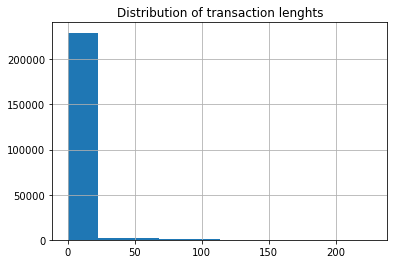

In [11]:
print(diff.sort_values('seconds', ascending=False).head())
diff['seconds'].hist()
plt.title('Distribution of transaction lenghts')

                 seconds  counts
trans_id_2                      
2021-07-27_40   0.000000       5
2021-05-11_103  0.000000       5
2022-01-31_75   0.000000       5
2020-11-28_17   8.234130       5
2020-11-28_14   0.000000       5
2020-11-27_99   4.858878       5
2022-01-31_65   0.000000       5
2021-09-02_75   0.000000       5
2021-06-09_11   0.000000       5
2022-01-31_56   0.000000       5


Text(0.5, 1.0, 'Distribution of transaction sizes')

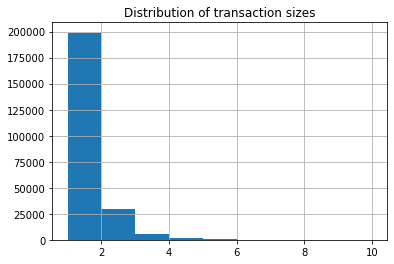

In [12]:
print(diff.sort_values('counts', ascending=False).head(10))
diff['counts'].hist(bins=[1,2,3,4,5,6,7,8,9,10])
plt.title('Distribution of transaction sizes')

In [13]:
# remove outlying transaction ids. 
# replace them with index id. 
df=c_co_out.copy()
df.loc[df[df['trans_id_2'].isin(diff[diff['counts']>6].index)].index ,\
       ['trans_id_2']]=df[df['trans_id_2'].isin(diff[diff['counts']>6].index)].index

In [14]:
len(set(list(df['trans_id_2'])))

235495

In [15]:
len(set(list(c_co_out['trans_id_2'])))

235495

In [16]:
# plots after removing outliers
diff2=df.groupby('trans_id_2')['seconds'].agg(np.ptp).to_frame('time_window')
diff2['counts_2']=df.groupby('trans_id_2').size()


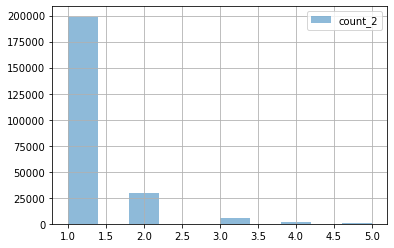

In [17]:
diff2['counts_2'].hist(alpha=0.5 ,label='count_2')

plt.legend()
plt.show()

<AxesSubplot:>

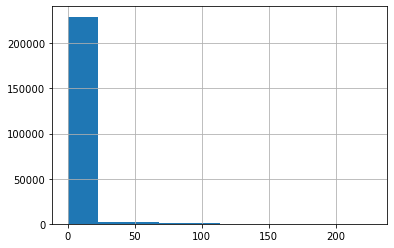

In [18]:
# time width of the transactions
diff2['time_window'].hist()

<AxesSubplot:>

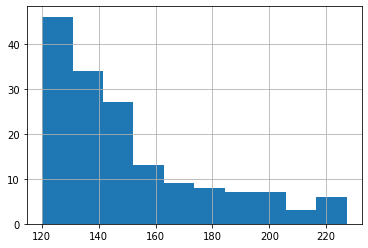

In [19]:
diff2[diff2['time_window']>120]['time_window'].hist()

In [20]:
diff2.shape

(235495, 2)

In [21]:
# if we had used only timestamp without clustering in time...
df.groupby(by=['NextOwnerId','OwnerSince']).size().sort_values(ascending=False).shape

(247990,)

In [22]:
diff2.shape[0]- df.groupby(by=['NextOwnerId','OwnerSince']).size().sort_values(ascending=False).shape[0]

-12495

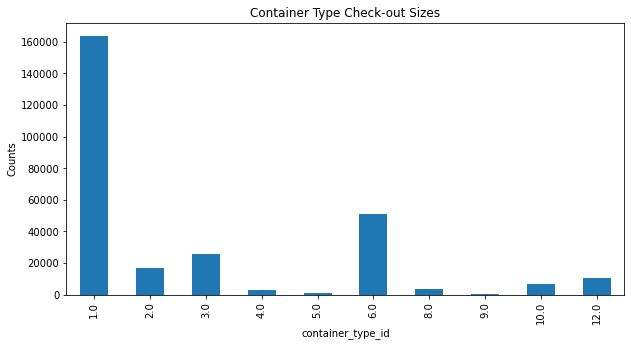

In [23]:
# plot how often which container types are check-out. 
# 
plt.figure(figsize=(10,5))
plt.title('Container Type Check-out Sizes')
plt.ylabel('Counts')

df.groupby(df['container_type_id']).size().plot.bar()

plt.show()

In [24]:
df[df['trans_id_2'].isna()]

,OwnerId,NextOwnerId,ContainerId,OwnerSince,OwnerTill,IsBillableTransaction,TransactionId,container_type_id,owner_store_id,next_owner_store_id,owner_co_int_,next_owner_co_int_,owner_claim_type,next_owner_claim_type,geometry,seconds,seconds_2,trans_id_2


In [25]:
df.tail(5)

,OwnerId,NextOwnerId,ContainerId,OwnerSince,OwnerTill,IsBillableTransaction,TransactionId,container_type_id,owner_store_id,next_owner_store_id,owner_co_int_,next_owner_co_int_,owner_claim_type,next_owner_claim_type,geometry,seconds,seconds_2,trans_id_2
498093,e5c7976f-92fb-408f-b852-01b98ba1723d,9c1a570a-2ec2-4167-a15a-71f48425a3a9,e1a1724f-7f0d-4a20-8634-b3d4e2fcb843,2022-03-04 15:21:04.174582+00:00,2022-03-04 16:31:27.886218+00:00,True,a84937d9-0962-4733-bc0a-4046b6a49066,1.0,e20e6c15-6507-4427-8b68-e1d1f870b924,NaN,False,False,storeappuser,consumer,POINT (2566096.0567991943 5646020.265491151),1.001065e+07,1.001065e+07,498093
498116,addf362b-e42f-491f-9700-ac906bf3c7c5,6bbeffb2-b856-4474-b618-1daf55071e5a,1b202077-6791-440d-ae80-25e5d6b38cb7,2022-03-04 15:36:53.106475+00:00,2022-03-04 16:44:01.608737+00:00,True,4fc54a69-a040-4b3e-959e-550ef2c4b5bf,3.0,415e2bd1-1253-4d42-a818-e519a606e18f,NaN,False,False,storeappuser,consumer,POINT (2565158.999204197 5643052.807053572),1.001074e+07,1.001074e+07,498116
498163,addf362b-e42f-491f-9700-ac906bf3c7c5,fb919c9b-4f0b-4814-8fc2-941e96e0c043,a09bddda-5704-4f75-83e7-aa966adc5664,2022-03-04 16:10:55.229060+00:00,2022-03-04 16:17:56.721385+00:00,True,fc5c60c0-26ca-4960-bc94-e4e9aea0573f,1.0,415e2bd1-1253-4d42-a818-e519a606e18f,NaN,False,False,storeappuser,consumer,POINT (2565158.999204197 5643052.807053572),1.001095e+07,1.001095e+07,2022-03-04_19
498164,addf362b-e42f-491f-9700-ac906bf3c7c5,fb919c9b-4f0b-4814-8fc2-941e96e0c043,e7d2ea07-664b-4826-a536-a85792a4c56a,2022-03-04 16:10:55.229060+00:00,2022-03-04 16:17:56.721385+00:00,True,fc5c60c0-26ca-4960-bc94-e4e9aea0573f,1.0,415e2bd1-1253-4d42-a818-e519a606e18f,NaN,False,False,storeappuser,consumer,POINT (2565158.999204197 5643052.807053572),1.001095e+07,1.001095e+07,2022-03-04_19
498165,addf362b-e42f-491f-9700-ac906bf3c7c5,fb919c9b-4f0b-4814-8fc2-941e96e0c043,e7c490e9-a02a-4801-936c-f293b5e86903,2022-03-04 16:10:55.229060+00:00,2022-03-04 16:17:56.721385+00:00,True,fc5c60c0-26ca-4960-bc94-e4e9aea0573f,1.0,415e2bd1-1253-4d42-a818-e519a606e18f,NaN,False,False,storeappuser,consumer,POINT (2565158.999204197 5643052.807053572),1.001095e+07,1.001095e+07,2022-03-04_19


## Association

In [26]:
basket= (df.groupby(['trans_id_2', 'container_type_id']).size().unstack().reset_index().fillna(0).set_index('trans_id_2'))


In [27]:
basket.head()

container_type_id,1.0,2.0,3.0,4.0,5.0,6.0,8.0,9.0,10.0,12.0
trans_id_2,,,,,,,,,,
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
# we change the matrix into 1: borrowed or 0: not borrowed. 
# In other words, we do not care about multiple borrowings of the same container types. 
# The question is here: is there any interaction between borrowings of different container types? 
#That refers exactly the associiation analysis. 
def hot_encode(x):
    if(x<= 0):
        return 0
    if(x>= 1):
        return 1

# Encoding the datasets
basket_encoded = basket.applymap(hot_encode)
basket = basket_encoded

In [29]:
basket

container_type_id,1.0,2.0,3.0,4.0,5.0,6.0,8.0,9.0,10.0,12.0
trans_id_2,,,,,,,,,,
1,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2022-03-04_5,1,0,0,0,0,0,0,0,0,0
2022-03-04_6,1,0,0,0,0,0,0,0,0,0
2022-03-04_7,0,0,0,0,0,1,0,0,0,0


In [30]:
set(list(basket.sum(axis=1)))

{1, 2, 3, 4}

In [31]:
# The number of items in transactions.
# People usually get only one container.

a=basket.sum(axis=1)

unique, counts = np.unique(a, return_counts=True)
print('Total number of transactions:',sum(counts))
print('The number of container types that are borrowed:')
dict(zip(unique, counts))

Total number of transactions: 235493
The number of container types that are borrowed:


{1: 226212, 2: 8781, 3: 485, 4: 15}

In [32]:
# create frequent itemsets
itemsets = apriori(basket, min_support=0.0001, use_colnames=True)

# and convert into rules
rules = association_rules(itemsets, metric='lift', min_threshold=1)
#rules.sort_values(by=['lift'], ascending=False).head(6)
rules.drop(columns=[ 'conviction', 'leverage']).sort_values(by=['lift'], ascending=False)
#

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
2,(8.0),(4.0),0.010616,0.010837,0.000399,0.037600,3.469646
3,(4.0),(8.0),0.010837,0.010616,0.000399,0.036834,3.469646
4,(10.0),(5.0),0.026247,0.004140,0.000140,0.005339,1.289521
5,(5.0),(10.0),0.004140,0.026247,0.000140,0.033846,1.289521
0,(2.0),(4.0),0.064257,0.010837,0.000718,0.011168,1.030594
1,(4.0),(2.0),0.010837,0.064257,0.000718,0.066223,1.030594


see the link for the definitions above in the dataframe (support, lift, etc.)
http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/ <br>


### End